# Looking at the anomalous stations, why are they so different depending on the method being used? Are there any clear reasons across stations?

Chambord Le Foret is the first station I will look at, with a very high difference between the two methods compared to other stations.


In [ ]:
from viresclient import SwarmRequest
import hapiclient
from hapiclient.util import pythonshell
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from chaosmagpy import load_CHAOS_matfile
from chaosmagpy.model_utils import synth_values
from chaosmagpy.data_utils import mjd2000 # Modified Julian date
from math import sqrt
import tqdm

import utils

In [ ]:
###Define station and time parameters, and OMNI parameters.

### Time parameters
start_date= 1998
end_date=2020

### Observatory parameters
observatory='CLF' 

### Download observatory metadata:
obsmeta = utils.fetch_ground_obs(observatory,'1998-01-01','1998-01-03')
latitude = obsmeta.attrs['Latitude_GEO']
longitude_deg = obsmeta.attrs['Longitude_GEO']
radius = obsmeta.attrs['Radius_GEO']


###OPTIONAL: input radius, latitude,longitude manually
#latitude=55.31
#longitude_deg=356.79 ##longitude is in degrees from Prime Meridian, i.e. 1 degree west is 359 degrees
#radius= 6371

# First, let us download the data and check the correct import mechanism is being used.

In [ ]:
###Step 1; Get year data into correct time indexing format


start_date_str= f'{start_date}-01-01'
end_date_str=f'{end_date}-01-01'

year_range=pd.date_range(start_date_str, end_date_str, freq='1YS')

print('list of years to be downloaded:')
print(year_range)

In [ ]:
###Step 2; Download magnetic field model for given station.


CHAOS7 = utils.loadChaosModel(start_date,end_date,latitude,longitude_deg)
CHAOS7

###NOTE: This function assumes constant radius, which is not the case; radius varies according to latitude and height
###from sea level. Change radius= parameter (last parameter in function) to get more accurate.

###Further NOTE: this function does not include the last 24 hours of the period in question. Consider
###changing this if possible.

In [163]:
###Step 3; loop over years and download observatory data
    
    
##Define start and end of download period for this year
start= start_date_str
end= end_date_str

print('Downloading Observatory data for',observatory,str(start)[:4],'to',str(end)[:4])

obs = utils.fetch_ground_obs(observatory, start, end)#Download obs data

print(obs)

obs = utils.manipulate_obs_data(obs,CHAOS7,option=2)#Manipulate obs data to remove background mag field


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (167.289MB)

<xarray.Dataset>
Dimensions:    (Timestamp: 11566080, NEC: 3)
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 1998-01-01 ... 2019-12-31T23:59:00
  * NEC        (NEC) <U1 'N' 'E' 'C'
Data variables:
    B_NEC      (Timestamp, NEC) float64 2.08e+04 -771.0 ... 369.6 4.31e+04
Attributes:
    Sources:         ['SW_OPER_AUX_OBSM2__19980101T000000_19980101T235959_010...
    MagneticModels:  []
    AppliedFilters:  []
    Latitude_GEO:    47.82557682325504
    Longitude_GEO:   2.266
    Radius_GEO:      6366509.931710675
Manipulating obsvervatory data


<xarray.Dataset>
Dimensions:    (Timestamp: 11566080)
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 1998-01-01 ... 2019-12-31T23:59:00
Data variables:
    B_N        (Timestamp) float64 -0.2587 -0.5594 -0.8588 ... 10.48 10.48 10.58
    B_E        (Timestamp) float64 5.746 5.647 5.347 ... -72.12 -72.22 -72.42
    B_C        (Timestamp) float64 14.99 15.19 14.99 ... -33.71 -33.71 -33.71
    B_H        (Timestamp) float64 -0.07429 -0.3785 -0.6887 ... 9.016 9.112
    dBdt       (Timestamp) float64 nan -0.3042 -0.3103 ... -0.001765 0.09647
    dBdt1      (Timestamp) float64 nan 0.3168 0.4237 ... 0.1415 0.1001 0.2237
Attributes:
    Sources:         ['SW_OPER_AUX_OBSM2__19980101T000000_19980101T235959_010...
    MagneticModels:  []
    AppliedFilters:  []
    Latitude_GEO:    47.82557682325504
    Longitude_GEO:   2.266
    Radius_GEO:      6366509.931710675


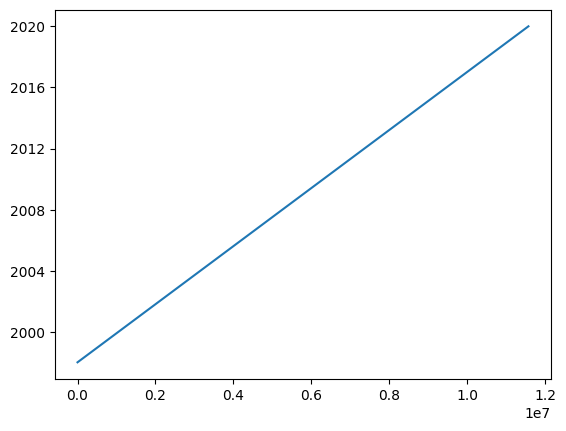

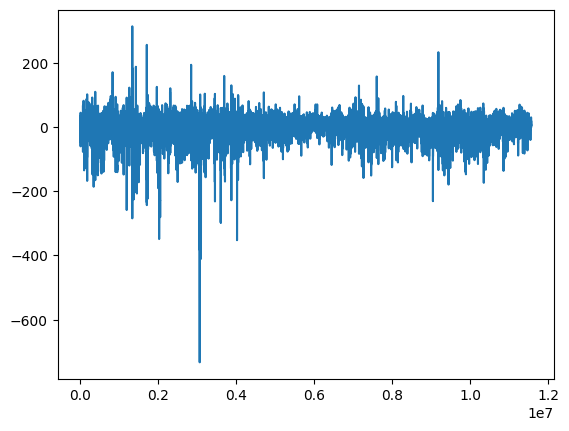

In [164]:
#print(events_tot['B_N'])

print(obs)

plt.plot(obs['Timestamp'])
plt.show()
plt.plot(obs['B_N'])
plt.show()

# Now, we look at the three time series that we are looking for: dBdt calculated both ways, and the difference between them.

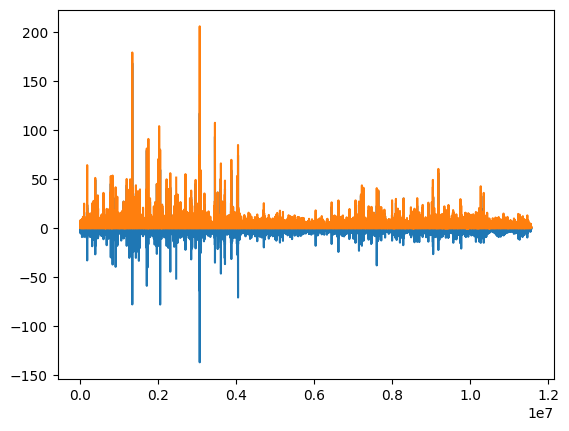

In [165]:
plt.figure()
plt.plot(obs['dBdt'])
plt.plot(obs['dBdt1'])
plt.show()

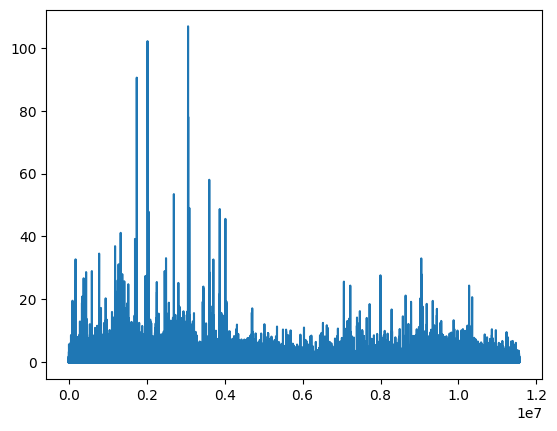

In [166]:
obs['dbdtdiff']=obs.dBdt1-((obs.dBdt)**2)**0.5
plt.plot(obs['dbdtdiff'])
plt.show()

# This next plot shows the ratio between dBdt(1) and dBdt(2).

As you can see, there is a lot to unpack here. There is one incident where one method is arbitrarily large compared to the other.

Apparently this took place on the 17th June 2011 at 8:45am UTC. (I assume it is UTC). This is 10:45am local time. Perhaps more interesting is the period just after from 2012-2016 with multiple "events". Unsure what this is corresponding to.

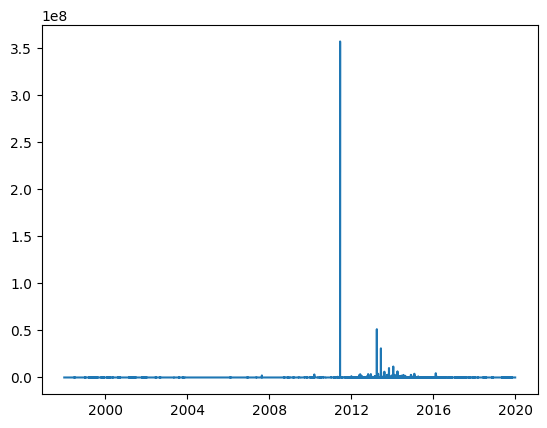

In [167]:
obs['dbdtdiff1']=((obs.dBdt1/obs.dBdt)**2)**0.5
plt.plot(obs['Timestamp'],obs['dbdtdiff1'])
plt.show()

In [168]:
max_index = obs['dbdtdiff1'].idxmax()

In [169]:
print(max_index)

<xarray.DataArray 'Timestamp' ()>
array('2011-06-17T08:45:00.000000000', dtype='datetime64[ns]')


In [170]:
filtered_obs = obs.sel(Timestamp=max_index)

# Print the values at the specific timestamp
print(filtered_obs)

<xarray.Dataset>
Dimensions:    ()
Coordinates:
    Timestamp  datetime64[ns] 2011-06-17T08:45:00
Data variables:
    B_N        float64 23.69
    B_E        float64 4.764
    B_C        float64 -5.392
    B_H        float64 23.59
    dBdt       float64 8.404e-10
    dBdt1      float64 0.2999
    dbdtdiff   float64 0.2999
    dbdtdiff1  float64 3.569e+08
Attributes:
    Sources:         ['SW_OPER_AUX_OBSM2__19980101T000000_19980101T235959_010...
    MagneticModels:  []
    AppliedFilters:  []
    Latitude_GEO:    47.82557682325504
    Longitude_GEO:   2.266
    Radius_GEO:      6366509.931710675


Now plot as a log plot.

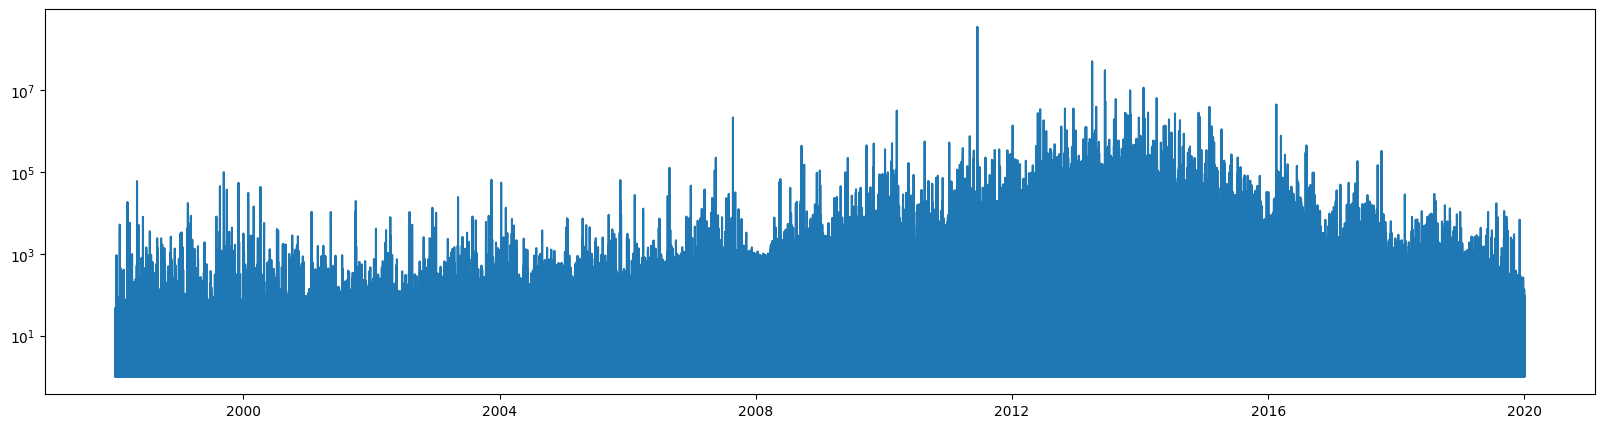

In [171]:
plt.figure(figsize=(20,5))
plt.plot(obs['Timestamp'],obs['dbdtdiff1'])
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()

##This result is very interesting. It seems to suggest that dBdt exceeds 10^5 times the size regularly.
##This also lends itself to the conclusion that storm times are not the times with the highest difference between
##the two methods.

##Look below. There is a peak in the difference between the two methods in approximately 2014. Unsure what this
##could be related to. I do think that this is definitely "something".

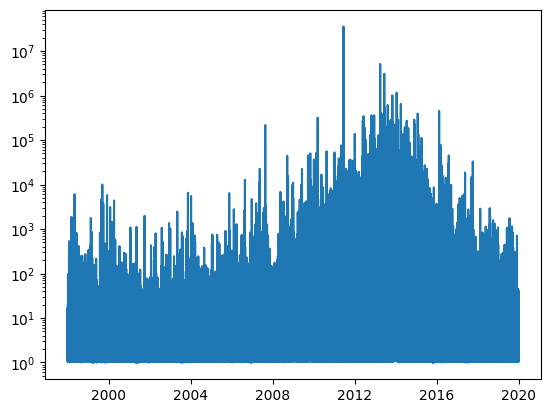

In [174]:
##Running average. 10 to 100000

rolling_avg = obs['dbdtdiff1'].rolling(Timestamp=10, min_periods=1).mean()
plt.plot(obs['Timestamp'],rolling_avg)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()

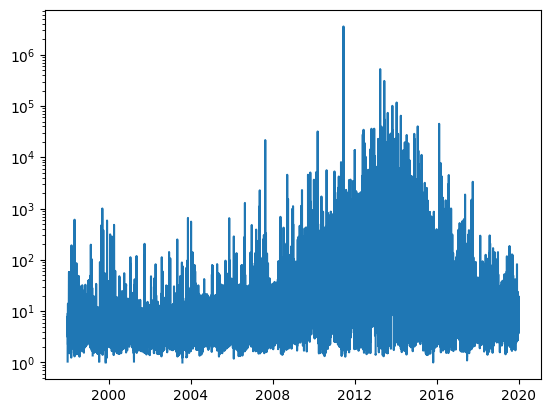

In [175]:
rolling_avg = obs['dbdtdiff1'].rolling(Timestamp=100, min_periods=1).mean()
plt.plot(obs['Timestamp'],rolling_avg)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()

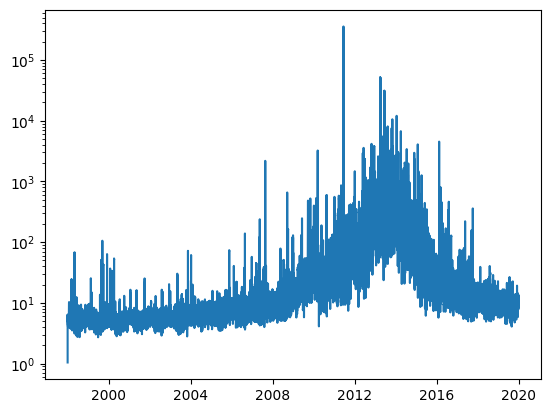

In [176]:
rolling_avg = obs['dbdtdiff1'].rolling(Timestamp=1000, min_periods=1).mean()
plt.plot(obs['Timestamp'],rolling_avg)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()

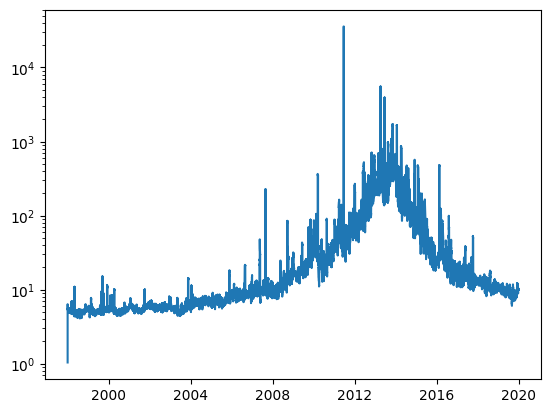

In [177]:
rolling_avg = obs['dbdtdiff1'].rolling(Timestamp=10000, min_periods=1).mean()
plt.plot(obs['Timestamp'],rolling_avg)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()

In [ ]:
rolling_avg = obs['dbdtdiff1'].rolling(Timestamp=100000, min_periods=1).mean()
plt.plot(obs['Timestamp'],rolling_avg)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()

# I will now look at the percentage of dBdt(calculated using the dBdt method used by Mervyn Freeman) is different between the two methods for each timestep.

This is also interesting-ish. What we see here is that the difference between the two methods never exceeds 1.00 as a ration of the size of dBdt from Mervyn Freeman. This makes a lot of sense; considering that |dHdt| can never exceed the size of dBdt (Freeman), what you see is that the maximum difference between the two methods is when diff is equal to 1x (dBdt (Freeman)), making the total ratio between the method difference and the dBdt(Freeman) is equal to 1.00. Will check with other stations though.

In [108]:
obs['dbdtdiffpercent']=(obs['dbdtdiff']/obs['dBdt1'])

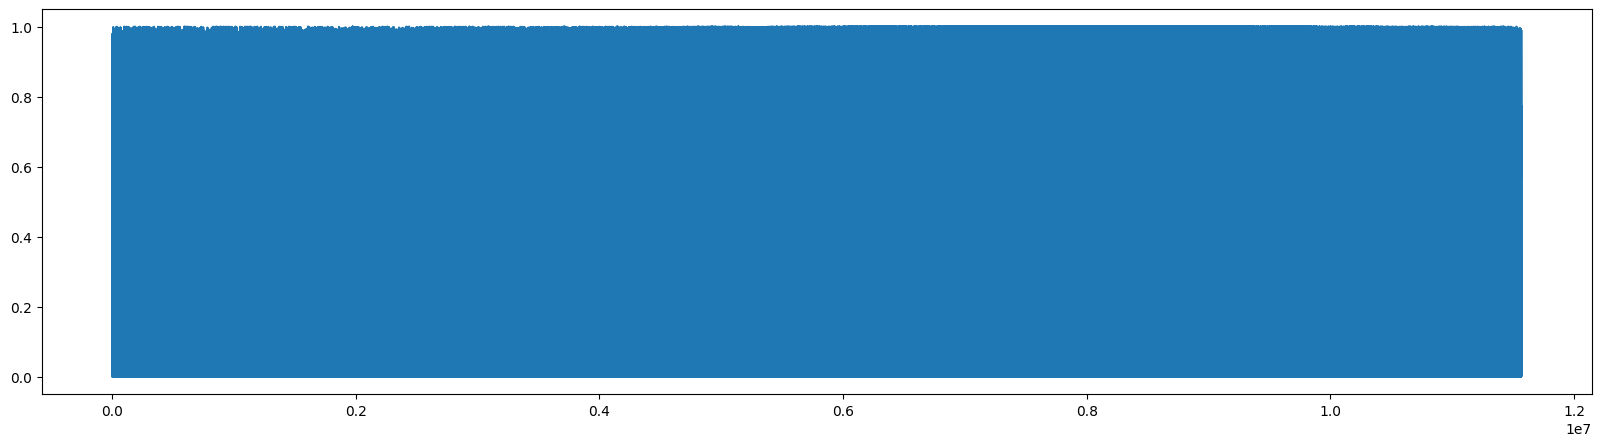

In [109]:
plt.figure(figsize=(20,5))
plt.plot(obs['dbdtdiffpercent'])

In [110]:
print(obs['dbdtdiffpercent'])

<xarray.DataArray 'dbdtdiffpercent' (Timestamp: 11566080)>
array([       nan, 0.03998051, 0.26782125, ..., 0.30585382, 0.98236932,
       0.56876683])
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 1998-01-01 ... 2019-12-31T23:59:00


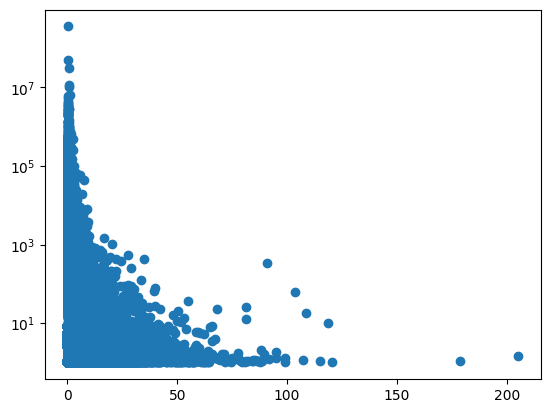

In [111]:
plt.scatter(obs['dBdt1'],obs['dbdtdiff1'])
plt.yscale('log')

# Other stations.
Starting with SBA. (Scott Base, Antarctica).

In [179]:
###Define station and time parameters, and OMNI parameters.

### Time parameters
start_date= 1998
end_date=2020

### Observatory parameters
observatory='SBA' 

### Download observatory metadata:
obsmeta = utils.fetch_ground_obs(observatory,'1998-01-01','1998-01-03')
latitude = obsmeta.attrs['Latitude_GEO']
longitude_deg = obsmeta.attrs['Longitude_GEO']
radius = obsmeta.attrs['Radius_GEO']


###OPTIONAL: input radius, latitude,longitude manually
#latitude=55.31
#longitude_deg=356.79 ##longitude is in degrees from Prime Meridian, i.e. 1 degree west is 359 degrees
#radius= 6371


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

In [180]:
###Step 1; Get year data into correct time indexing format


start_date_str= f'{start_date}-01-01'
end_date_str=f'{end_date}-01-01'

year_range=pd.date_range(start_date_str, end_date_str, freq='1YS')

print('list of years to be downloaded:')
print(year_range)

list of years to be downloaded:
DatetimeIndex(['1998-01-01', '1999-01-01', '2000-01-01', '2001-01-01',
               '2002-01-01', '2003-01-01', '2004-01-01', '2005-01-01',
               '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01',
               '2018-01-01', '2019-01-01', '2020-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')


In [181]:
###Step 2; Download magnetic field model for given station.


CHAOS7 = utils.loadChaosModel(start_date,end_date,latitude,longitude_deg)
CHAOS7

###NOTE: This function assumes constant radius, which is not the case; radius varies according to latitude and height
###from sea level. Change radius= parameter (last parameter in function) to get more accurate.

###Further NOTE: this function does not include the last 24 hours of the period in question. Consider
###changing this if possible.

,B_radius,B_phi,B_theta,B_H
1998-01-01 00:00:00,62176.309500,5556.647476,7952.675977,9701.617719
1998-01-01 00:01:00,62176.309396,5556.647539,7952.676007,9701.617779
1998-01-01 00:02:00,62176.309292,5556.647602,7952.676036,9701.617839
1998-01-01 00:03:00,62176.309188,5556.647664,7952.676065,9701.617899
1998-01-01 00:04:00,62176.309085,5556.647727,7952.676094,9701.617959
...,...,...,...,...
2020-12-30 23:56:00,60921.490788,6530.132264,8150.862475,10444.098164
2020-12-30 23:57:00,60921.490788,6530.132264,8150.862475,10444.098164
2020-12-30 23:58:00,60921.490788,6530.132264,8150.862475,10444.098164
2020-12-30 23:59:00,60921.490788,6530.132264,8150.862475,10444.098164


In [182]:
###Step 3; loop over years and download observatory data
    
    
##Define start and end of download period for this year
start= start_date_str
end= end_date_str

print('Downloading Observatory data for',observatory,str(start)[:4],'to',str(end)[:4])

obs = utils.fetch_ground_obs(observatory, start, end)#Download obs data

print(obs)

obs = utils.manipulate_obs_data(obs,CHAOS7,option=2)#Manipulate obs data to remove background mag field


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (245.907MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (245.656MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (167.45MB)

<xarray.Dataset>
Dimensions:    (Timestamp: 11527200, NEC: 3)
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 1998-01-01 ... 2019-12-31T23:59:00
  * NEC        (NEC) <U1 'N' 'E' 'C'
Data variables:
    B_NEC      (Timestamp, NEC) float64 -1.025e+04 4.552e+03 ... -6.499e+04
Attributes:
    Sources:         ['SW_OPER_AUX_OBSM2__19980101T000000_19980101T235959_010...
    MagneticModels:  []
    AppliedFilters:  []
    Latitude_GEO:    -77.77057066843713
    Longitude_GEO:   166.783
    Radius_GEO:      6357716.953176827
Manipulating obsvervatory data


<xarray.Dataset>
Dimensions:    (Timestamp: 11527200)
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 1998-01-01 ... 2019-12-31T23:59:00
Data variables:
    B_N        (Timestamp) float64 25.21 21.98 22.4 24.16 ... 6.619 9.62 10.72
    B_E        (Timestamp) float64 -37.02 -34.21 -32.95 ... -70.16 -73.16 -76.46
    B_C        (Timestamp) float64 -98.66 -100.9 -100.4 ... -112.1 -111.2 -111.2
    B_H        (Timestamp) float64 68.89 67.08 67.97 ... -101.6 -100.3 -100.9
    dBdt       (Timestamp) float64 nan -1.814 0.8961 ... 1.155 1.259 -0.5625
    dBdt1      (Timestamp) float64 nan 4.284 1.328 4.537 ... 2.781 4.244 3.479
Attributes:
    Sources:         ['SW_OPER_AUX_OBSM2__19980101T000000_19980101T235959_010...
    MagneticModels:  []
    AppliedFilters:  []
    Latitude_GEO:    -77.77057066843713
    Longitude_GEO:   166.783
    Radius_GEO:      6357716.953176827


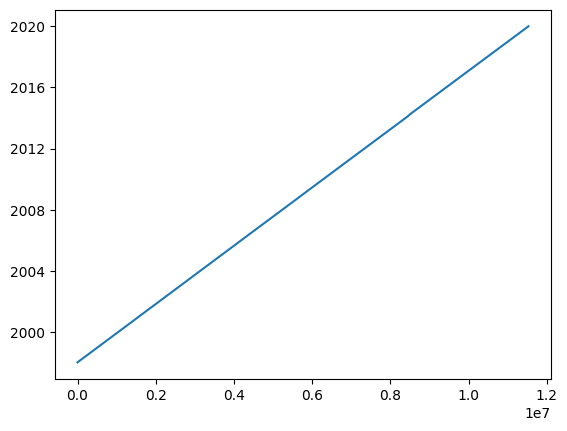

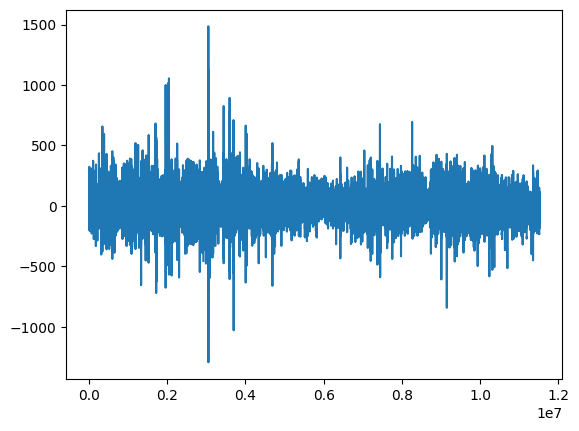

In [183]:
#print(events_tot['B_N'])

print(obs)

plt.plot(obs['Timestamp'])
plt.show()
plt.plot(obs['B_N'])
plt.show()

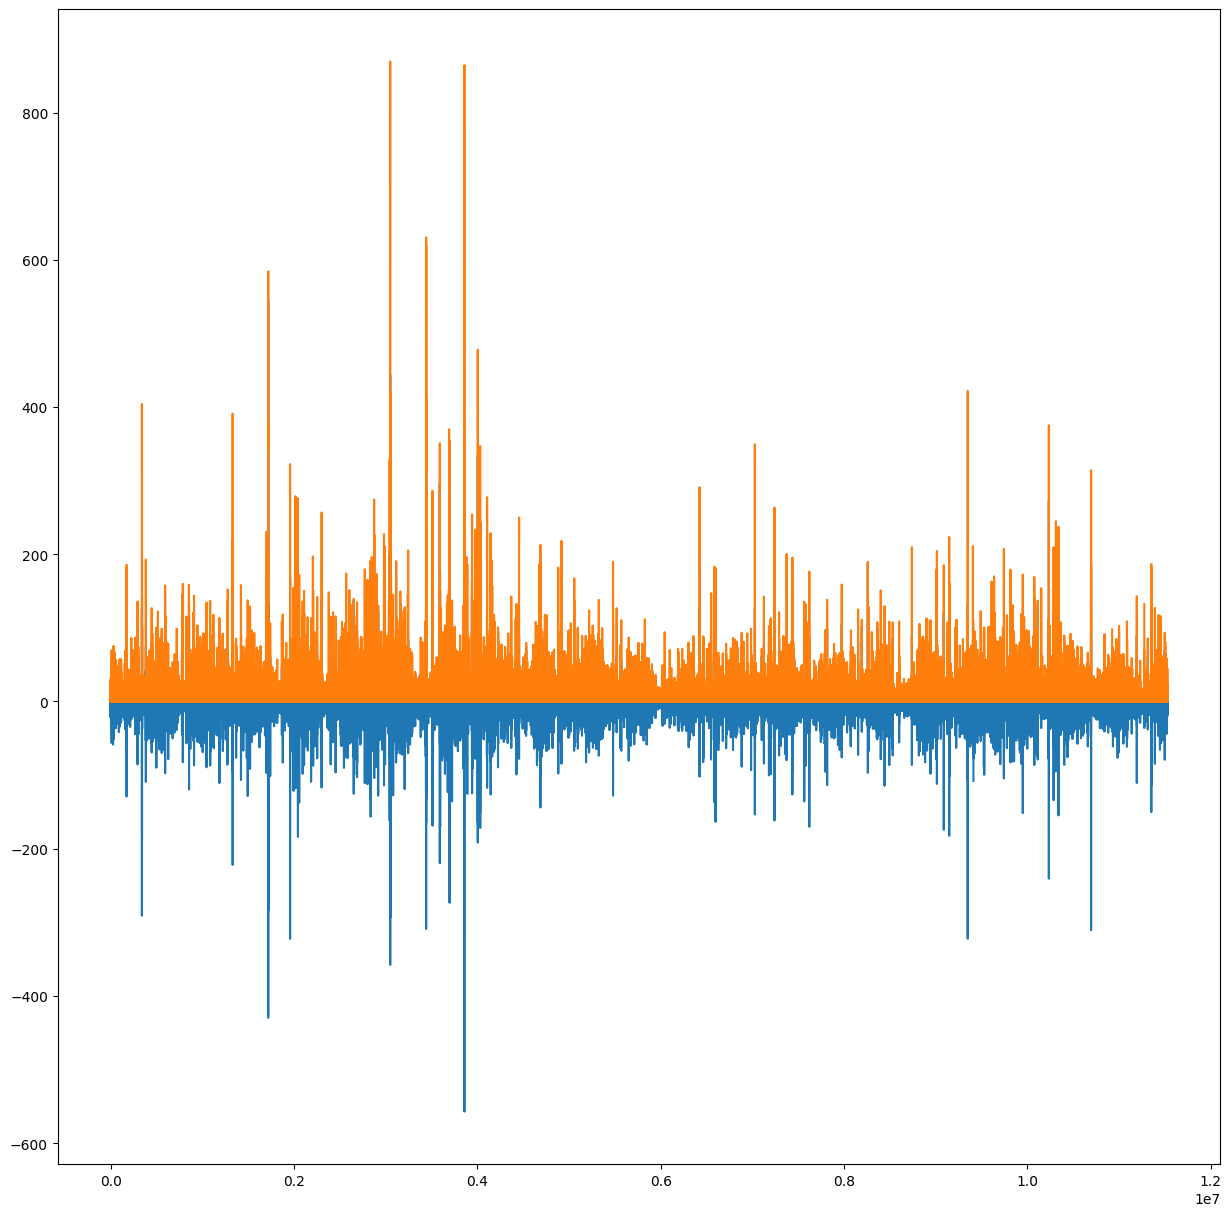

In [184]:
plt.figure(figsize=(15,15))
plt.plot(obs['dBdt'])
plt.plot(obs['dBdt1'])
plt.show()

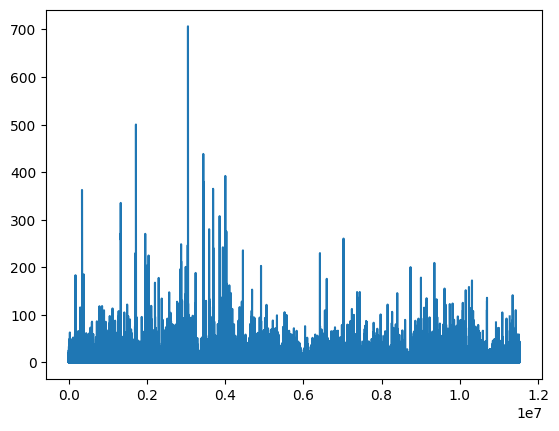

In [185]:
obs['dbdtdiff']=obs.dBdt1-((obs.dBdt)**2)**0.5
plt.plot(obs['dbdtdiff'])
plt.show()

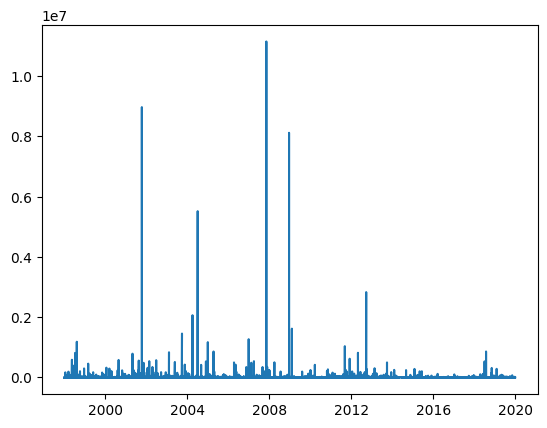

In [186]:
obs['dbdtdiff1']=((obs.dBdt1/obs.dBdt)**2)**0.5
plt.plot(obs['Timestamp'],obs['dbdtdiff1'])
plt.show()

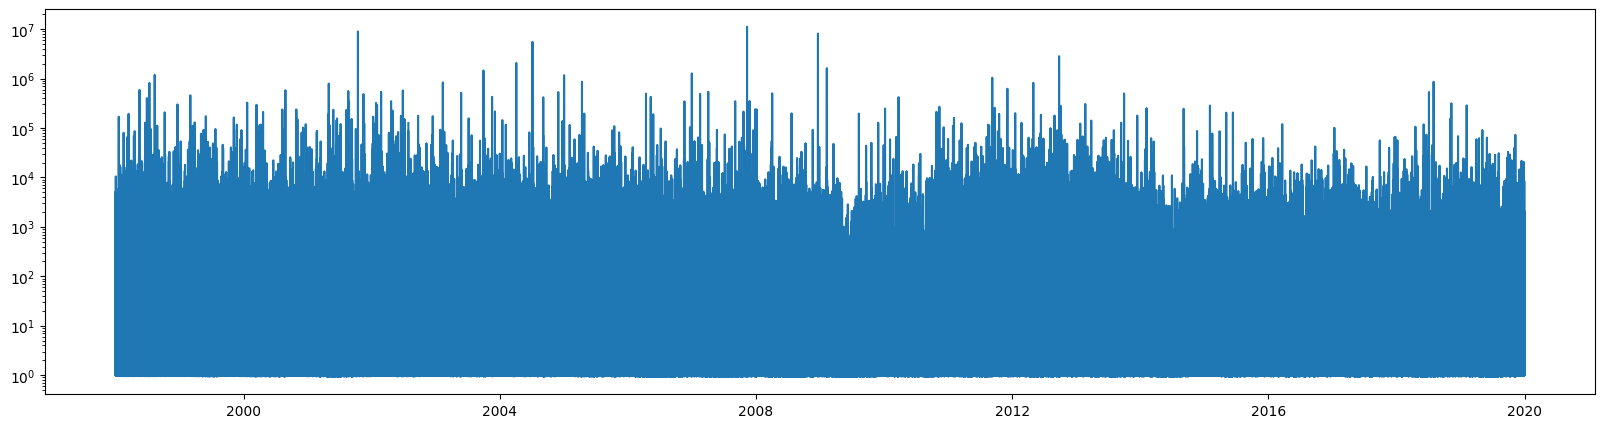

In [187]:
plt.figure(figsize=(20,5))
plt.plot(obs['Timestamp'],obs['dbdtdiff1'])
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()

##This result is very interesting. It seems to suggest that dBdt exceeds 10^5 times the size regularly.
##This also lends itself to the conclusion that storm times are not the times with the highest difference between
##the two methods.

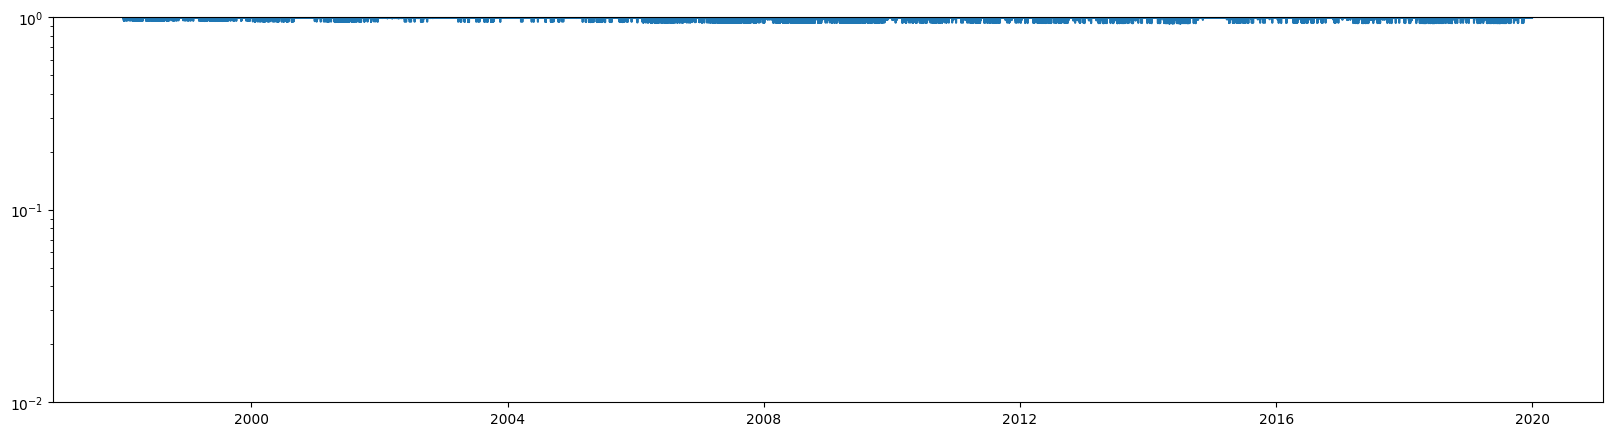

In [188]:
plt.figure(figsize=(20,5))
plt.plot(obs['Timestamp'],obs['dbdtdiff1'])
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.ylim(0.01,1)
plt.show()

##This result is very interesting. It seems to suggest that dBdt exceeds 10^5 times the size regularly.
##This also lends itself to the conclusion that storm times are not the times with the highest difference between
##the two methods.

##Another comment. Clearly some places where dHdt is greater than dBdt(Freeman). See below. These values show there are some
##points where dBdt(Freeman)/dHdt <1.

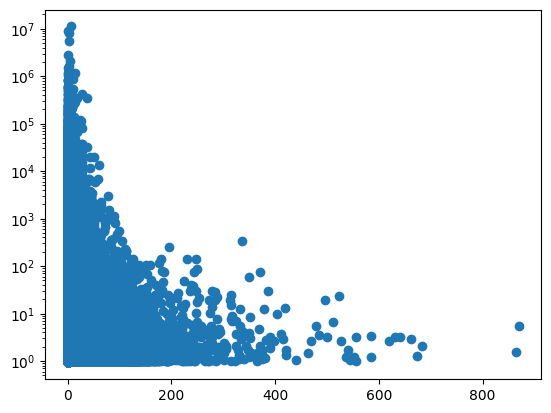

In [189]:
plt.scatter(obs['dBdt1'],obs['dbdtdiff1'])
plt.yscale('log')

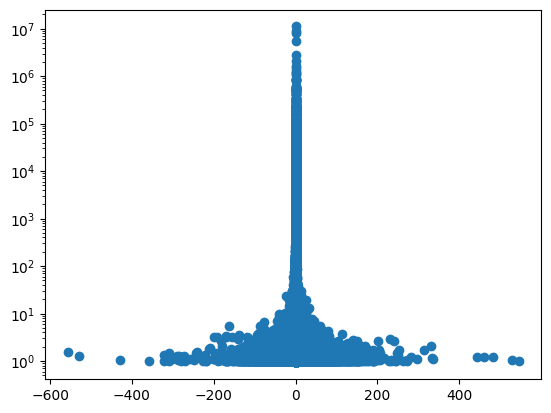

In [190]:
plt.scatter(obs['dBdt'],obs['dbdtdiff1'])
plt.yscale('log')

In [191]:
obs['dbdtdiffpercent']=(obs['dbdtdiff']/obs['dBdt1'])


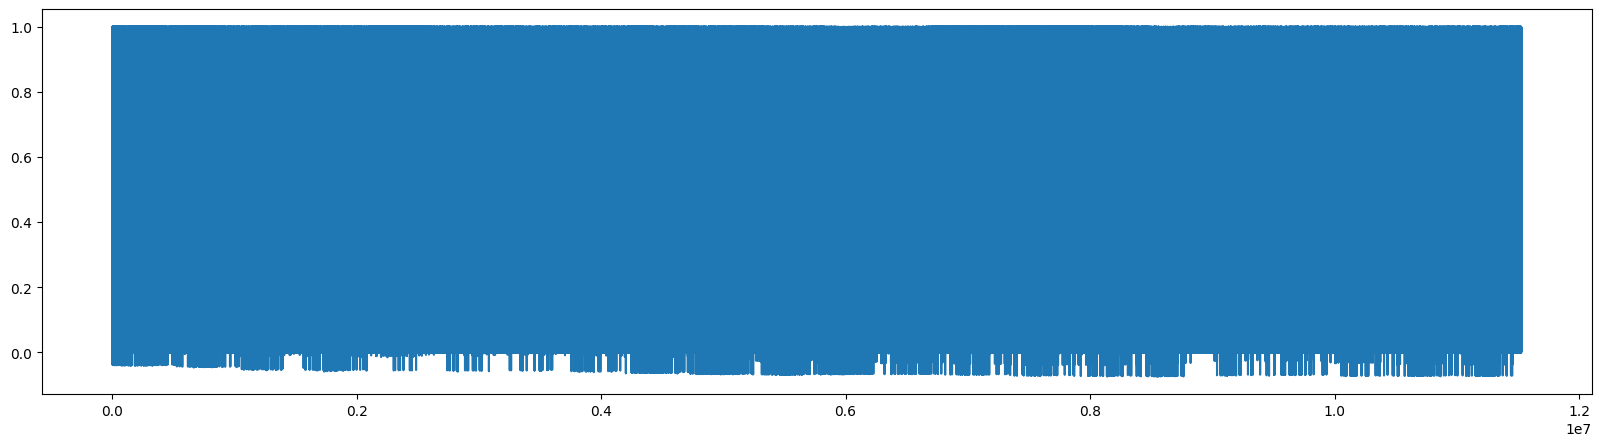

In [192]:
plt.figure(figsize=(20,5))
plt.plot(obs['dbdtdiffpercent'])

In [193]:
print(obs['dbdtdiff'].min())


<xarray.DataArray 'dbdtdiff' ()>
array(-1.59729181e-05)


# Discussion on negative values appearing, where dHdt is greater than dBdt(Freeman).

Mathematically and physically speaking, it should be impossible for dHdt to be greater than dBdt. However, the reality appears to be that for the station at Scott Base there are certain times (though they make up a minority of times) where dBdt(Freeman) is less than dHdt. The reason for this appears to be the use of the CHAOS model in the utilities; the utilities calculate the BH value from the BN and BE values using BH=sqrt(BN^2+BE^2), and then takes away predicted BH (CHAOS) from that model. Clearly this method of calculating a corrected BH causes inconsistencies when propogating through the data, especially at high latitude stations where a slight difference in BH can cause significant differences in dBdt values. Discussion should take place as to whether using this BH CHAOS model is a good idea- I would claim a better idea is to subtract the CHAOS model from the individual components and then propogate through. This would get rid of this kind of mathematical error.

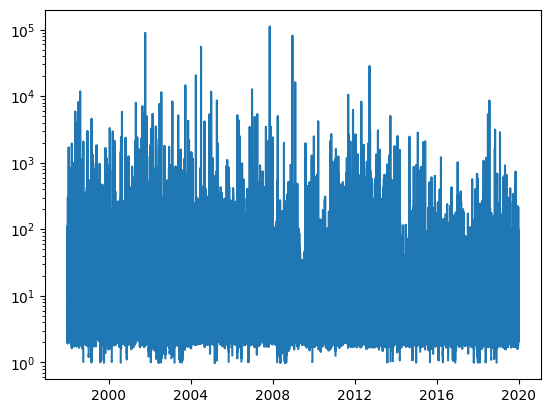

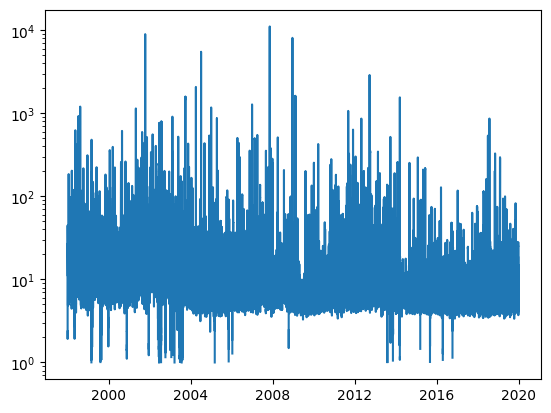

In [194]:
##Rolling windows for SBA.
rolling_avg = obs['dbdtdiff1'].rolling(Timestamp=100, min_periods=1).mean()
plt.plot(obs['Timestamp'],rolling_avg)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()


rolling_avg = obs['dbdtdiff1'].rolling(Timestamp=1000, min_periods=1).mean()
plt.plot(obs['Timestamp'],rolling_avg)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()

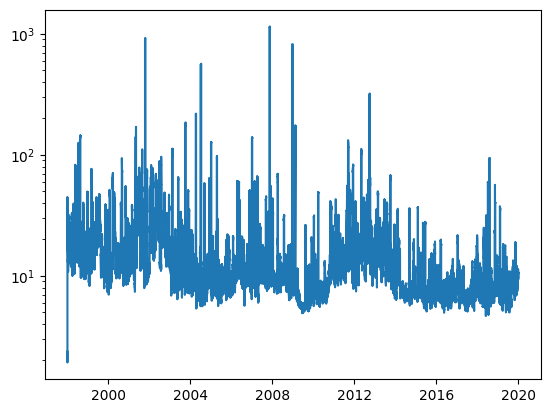

In [195]:

rolling_avg = obs['dbdtdiff1'].rolling(Timestamp=10000, min_periods=1).mean()
plt.plot(obs['Timestamp'],rolling_avg)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()

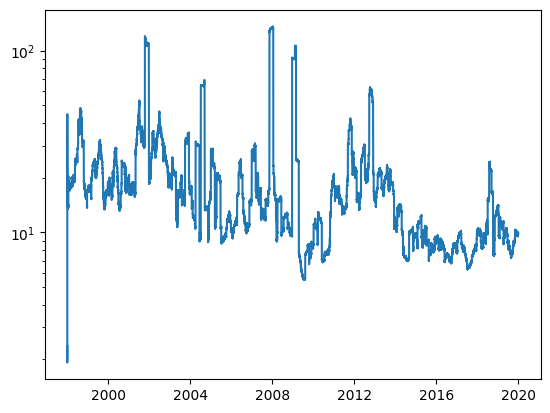

In [196]:

rolling_avg = obs['dbdtdiff1'].rolling(Timestamp=100000, min_periods=1).mean()
plt.plot(obs['Timestamp'],rolling_avg)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()